In [44]:
# %pip install seaborn 
# %pip install matplotlib


In [45]:
import pandas as pd 
import mysql.connector
import matplotlib.pyplot as plt 
import seaborn as sns

In [46]:
db = mysql.connector.connect(
  host = "localhost", 
  username = "root",
  password = "P@war2330",
  database = "TARGET_SALES"
)

In [47]:
curr = db.cursor()

List all Unique cities where customers are located 

In [48]:
query = """ select distinct customer_city from customers """
curr.execute(query)
data = curr.fetchall()
data

data = pd.Series(data) # all unique cities 





Count the number of orders in 2017 

In [49]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
curr.execute(query)
order_2017 = curr.fetchall()
order_2017

[(180404,)]

total sales in every category 

In [50]:
query =  """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category """

curr.execute(query)
data = curr.fetchall() 
data
data  = pd.DataFrame(data, columns = ["Category" , "Sales"])
data

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### Calculate the percentage of orders that were paid in installments.

In [51]:
query =  """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments

"""
curr.execute(query)
data = curr.fetchall()
data = data[0][0]
data 

Decimal('99.9981')

### Count the number of customers from each state.

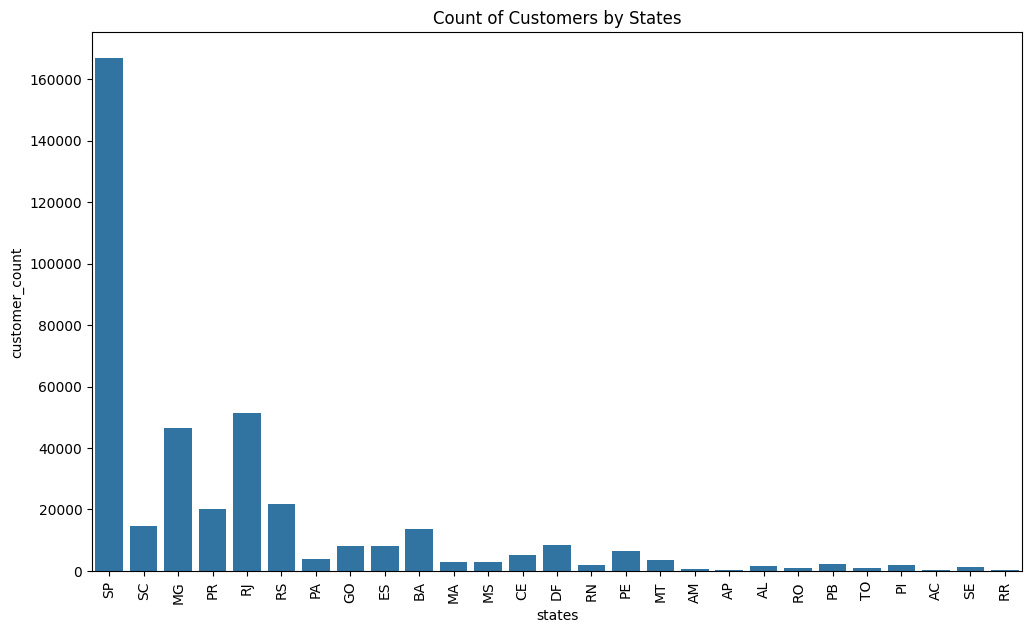

In [52]:
query = """ select customer_state, count(customer_id) from customers group by customer_state
 """
curr.execute(query)
data = curr.fetchall()
data =  pd.DataFrame(data , columns=["state", "Customer_count"])
data 

plt.figure(figsize = (12,7))
plt.title("Count of customers by state")
sns.barplot(x='state', y = "Customer_count", data=data)
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

### Calculate the Number of orders per Month in 2018

<Axes: xlabel='months', ylabel='order_count'>

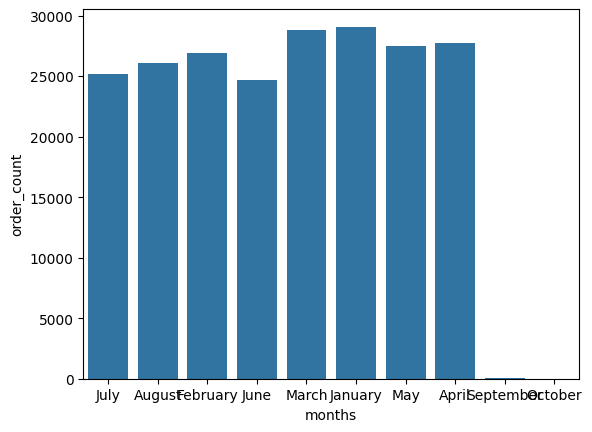

In [53]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count from orders where year(order_purchase_timestamp) = 2018 
group by months """

curr.execute(query)
data = curr.fetchall()
df = pd.DataFrame(data , columns= ["months", "order_count"])
df


sns.barplot(x = 'months', y = "order_count", data= df)


### Find the average number of products per order, grouped by customer city.

In [54]:

query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""
curr.execute(query)
data = curr.fetchall()
data = pd.DataFrame(data)
data 

,0,1
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
...,...,...
4105,tuiuti,4.00
4106,sambaiba,4.00
4107,japaratuba,4.00
4108,tibau do sul,4.00


### Calculate the percentage of total revenue contributed by each product category.

In [55]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""
curr.execute(query)
data = curr.fetchall()

### 
Identify the correlation between product price and the number of times a product has been purchased.

In [56]:
# import numpy as np 
# cur = db.cursor()
# query = """select products.product_category, 
# count(order_items.product_id),
# round(avg(order_items.price),2)
# from products join order_items
# on products.product_id = order_items.product_id
# group by products.product_category"""

# cur.execute(query)
# data = cur.fetchall()
# df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

# arr1 = df["order_count"]
# arr2 = df["price"]

# a = np.corrcoef([arr1,arr2])
# print("the correlation is", a[0][-1])

### 
Calculate the total revenue generated by each seller, and rank them by revenue.

In [61]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

curr.execute(query)
data = curr.fetchall()
data = pd.DataFrame(data)
data.head(2)

,0,1,2
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2


### Calculate the cumulative sales per month for each year.

In [64]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""

curr.execute(query)
data = curr.fetchall()
pd.DataFrame(data)

,0,1,2,3
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56



### Calculate the year-over-year growth rate of total sales.

In [66]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

curr.execute(query)
data = curr.fetchall()

data = pd.DataFrame(data, columns=["years","yoy % growth"])
data


,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924




### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [67]:

query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

curr.execute(query)
data = curr.fetchall()
data

[(None,)]

### 
Identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

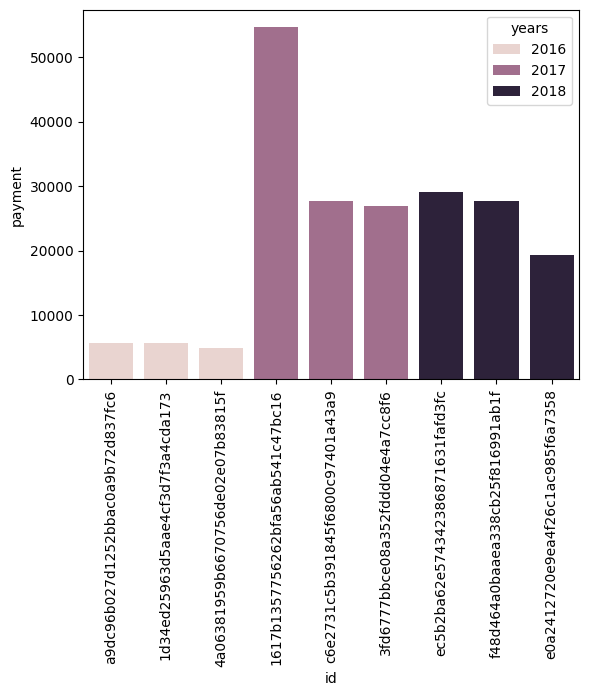

In [71]:

query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

curr.execute(query)
data = curr.fetchall()
data = pd.DataFrame(data,columns=["years","id", "payment", "Ranks"])

sns.barplot(x = "id", y ="payment",hue = "years", data = data)
plt.xticks(rotation = 90)